### A machine learning based station classification for global air quality data.

This notebook content the code for "A machine learning based station classification for global air quality
data" paper.

In [44]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from itertools import product
from pathlib import Path
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier,  plot_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import manifold
from sklearn.cluster import KMeans, DBSCAN, Birch, HDBSCAN, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import *
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Markdown
from collections import Counter
import gc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
import cartopy.crs as ccrs
import cartopy
from sklearn.utils import shuffle
import plotly.express as px
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
from sklearn.utils import shuffle
from fancyimpute import IterativeImputer
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#0b5394", 
              "weight": "bold", 
              "size": 14}
# Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':12,
     'ytick.labelsize':12,
     'axes.labelsize': 12, 
     'legend.fontsize': 12, 
     'axes.titlesize': 12, 
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

### Some hand-labelled stations for testing

In [62]:
test_cord_urban = ['GB0682A', 'GB1072A', 'GB1095A', 'GB0960A', 'GB1035A', 'DEBE092', 'DEHH026', 'DENW376',  'DEBW118', 'FR04118', 'ES1422A',
                    'IT1016A', '36-081-0124', '13-121-0001', '06-037-4002','openaq_225445', 'jp23105510']

test_cord_suburban = ['GB1092A', 'GB0885A', 'FR21031', '06-037-0019', 'jp20421030']

test_cord_rural = ['GB1055R', 'GB0013R', 'GB0006R', 'IE0031R', 'NO0015R', 'FI00363', 'DENI051', 'DENW192', 'DERP015', 'FR23068', 'FR19020',
                   'ES1616A', 'IT1942A', 'MT0001R', '37-105-0002', '08-123-0013','06-111-0005', 'openaq_230819', 'openaq_226125', 'jp21601010']

test_cord = {'urban': test_cord_urban, 'suburban':test_cord_suburban, 'rural':test_cord_rural}

categories = ['urban', 'suburban', 'rural']

In [63]:
df_no2 = pd.read_csv('no2/p75.csv', comment="#")
df_no2.set_index(['lat', 'lon'], inplace=True)
df_no2 = df_no2.loc[~df_no2.index.duplicated(keep=False)]
df_no2 = df_no2.rename(columns={'value': 'no2'})

df_nox = pd.read_csv('nox/p75.csv', comment="#")
df_nox.set_index(['lat', 'lon'], inplace=True)
df_nox = df_nox.loc[~df_nox.index.duplicated(keep=False)]
df_nox = df_nox.rename(columns={'value': 'nox'})
df_nox = df_nox.dropna()

df_pm = pd.read_csv('pm2p5/p75.csv', comment="#")
df_pm.set_index(['lat', 'lon'], inplace=True)
df_pm = df_pm.loc[~df_pm.index.duplicated(keep=False)]
df_pm = df_pm.rename(columns={'value': 'pm2p5'})

### Some useful functions for data preparation and data preprocessing

In [65]:
def read_spice_data():
    pass

def get_station_cord(station_code):
    data_point = requests.get(f'https://toar-data.fz-juelich.de/api/v2/stationmeta/{station_code}').json()
    cord = {}
    cord['lat'] = data_point['coordinates']['lat']
    cord['lon'] = data_point['coordinates']['lng']
    cord['type_of_area'] = data_point['type_of_area']
    cord['alt'] = data_point['coordinates']['alt']
    return cord

def get_test_data_from_station_code(station_codes):
    type_of_area_truth = []
    type_of_area_given = []
    area_code = []
    lat = []
    lon = []
    alt = []
    for area_type, st_code in station_codes.items():
        for code in st_code:
            data_point_cord = get_station_cord(code)
            lat.append(data_point_cord['lat'])
            lon.append(data_point_cord['lon'])
            alt.append(data_point_cord['alt'])
            type_of_area_truth.append(data_point_cord['type_of_area'])
            type_of_area_given.append(area_type)
            area_code.append(code)
    df = pd.DataFrame({'lat':lat, 'lon':lon, 'area_code': area_code, 'type_of_are_truth': type_of_area_truth,  'type_of_area_given': type_of_area_given})
    return df

def get_station_codes(n:int = 1000):
    "return the first n station codes in the TOAR databse"
    stations_codes = requests.get(f'https://toar-data.fz-juelich.de/api/v2/search/?limit={n}&fields=codes').json()
    return [station_code['codes'][0] for station_code in stations_codes]

def groupe_landcover_cat(df):
    landcover = df['dominant_landcover_year2012'].unique()
    dominant_landcover = {}
    for key in landcover:
        dominant_landcover[key] = (key//10)*10
    df['dominant_landcover_year2012'] = df['dominant_landcover_year2012'].replace(dominant_landcover)
    return df

def encode_categorical_variables(df):
    df = groupe_landcover_cat(df)
    df['climatic_zone_year2016'] = df['climatic_zone_year2016'].astype('category')
    df['dominant_landcover_year2012'] = df['dominant_landcover_year2012'].astype('category')
    df = pd.get_dummies(df, columns=['climatic_zone_year2016', 'dominant_landcover_year2012'], dtype=float)
    return df

def get_N_first_station_data(data_points=None, N:int=1000, n_sample:int=24):
    type_of_area = []
    area_code = []
    lat = []
    lon = []
    alt = []
    mean_topography_srtm_alt_90m_year1994 = []
    mean_topography_srtm_alt_1km_year1994 = []
    max_topography_srtm_relative_alt_5km_year1994 = []
    min_topography_srtm_relative_alt_5km_year1994 = []
    stddev_topography_srtm_relative_alt_5km_year1994 =[]
    climatic_zone_year2016 = []
    
    distance_to_major_road_year2020 = []
    mean_stable_nightlights_1km_year2013 = []
    mean_stable_nightlights_5km_year2013 = []
    max_stable_nightlights_25km_year2013 = []
    
    max_stable_nightlights_25km_year1992 = []
    mean_population_density_250m_year2015 = []
    mean_population_density_5km_year2015 = []
    max_population_density_25km_year2015 = []
    mean_population_density_250m_year1990 = []
    mean_population_density_5km_year1990 = []
    max_population_density_25km_year1990 = []
    mean_nox_emissions_10km_year2015 = []
    mean_nox_emissions_10km_year2000 = []
    if data_points is None:
        data_points= [requests.get(f'https://toar-data.fz-juelich.de/api/v2/stationmeta/?limit={N}&offset={i*N}').json() for i in range(n_sample)]
        data_points = [datapoint for datapoints_sublist in data_points for datapoint in datapoints_sublist]              
    for data_point in data_points:
        type_of_area.append(data_point['type_of_area'])
        area_code.append(data_point['codes'][0])
        lat.append(data_point['coordinates']['lat'])
        lon.append(data_point['coordinates']['lng'])
        alt.append(data_point['coordinates']['alt'])
        distance_to_major_road_year2020.append(data_point['globalmeta']['distance_to_major_road_year2020'])
        mean_stable_nightlights_1km_year2013.append(data_point['globalmeta']['mean_stable_nightlights_1km_year2013'])
        mean_stable_nightlights_5km_year2013.append(data_point['globalmeta']['mean_stable_nightlights_5km_year2013'])
        max_stable_nightlights_25km_year2013.append(data_point['globalmeta']['max_stable_nightlights_25km_year2013'])
        max_stable_nightlights_25km_year1992.append(data_point['globalmeta']['max_stable_nightlights_25km_year1992'])
        mean_population_density_250m_year2015.append(data_point['globalmeta']['mean_population_density_250m_year2015'])
        mean_population_density_5km_year2015.append(data_point['globalmeta']['mean_population_density_5km_year2015'])
        max_population_density_25km_year2015.append(data_point['globalmeta']['max_population_density_25km_year2015'])
        mean_population_density_250m_year1990.append(data_point['globalmeta']['mean_population_density_250m_year1990'])
        mean_population_density_5km_year1990.append(data_point['globalmeta']['mean_population_density_5km_year1990'])
        max_population_density_25km_year1990.append(data_point['globalmeta']['max_population_density_25km_year1990'])
        mean_nox_emissions_10km_year2015.append(data_point['globalmeta']['mean_nox_emissions_10km_year2015'])
        mean_nox_emissions_10km_year2000.append(data_point['globalmeta']['mean_nox_emissions_10km_year2000'])
        mean_topography_srtm_alt_90m_year1994.append(data_point['globalmeta']['mean_topography_srtm_alt_90m_year1994'])
        mean_topography_srtm_alt_1km_year1994.append(data_point['globalmeta']['mean_topography_srtm_alt_1km_year1994'])
        max_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['max_topography_srtm_relative_alt_5km_year1994'])
        min_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['min_topography_srtm_relative_alt_5km_year1994'])
        stddev_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['stddev_topography_srtm_relative_alt_5km_year1994'])
        climatic_zone_year2016.append(data_point['globalmeta']['climatic_zone_year2016'])
        
    dataset = pd.DataFrame({'lat': lat,
                            'lon': lon,
                            'altitude': alt,
                            'mean_topography_srtm_alt_90m_year1994': mean_topography_srtm_alt_90m_year1994,
                            'mean_topography_srtm_alt_1km_year1994': mean_topography_srtm_alt_1km_year1994,
                            'max_topography_srtm_relative_alt_5km_year1994': max_topography_srtm_relative_alt_5km_year1994,
                            'min_topography_srtm_relative_alt_5km_year1994': min_topography_srtm_relative_alt_5km_year1994,
                            'stddev_topography_srtm_relative_alt_5km_year1994': stddev_topography_srtm_relative_alt_5km_year1994,
                            'climatic_zone_year2016': climatic_zone_year2016,
                            'distance_to_major_road_year2020': distance_to_major_road_year2020,
                            'mean_stable_nightlights_1km_year2013': mean_stable_nightlights_1km_year2013,
                            'mean_stable_nightlights_5km_year2013': mean_stable_nightlights_5km_year2013,
                            'max_stable_nightlights_25km_year2013': max_stable_nightlights_25km_year2013,
                            'max_stable_nightlights_25km_year1992': max_stable_nightlights_25km_year1992,
                            'mean_population_density_250m_year2015': mean_population_density_250m_year2015,
                            'mean_population_density_5km_year2015': mean_population_density_5km_year2015,
                            'max_population_density_25km_year2015': max_population_density_25km_year2015,
                            'mean_population_density_250m_year1990': mean_population_density_250m_year1990,
                            'mean_population_density_5km_year1990': mean_population_density_5km_year1990,
                            'max_population_density_25km_year1990': max_population_density_25km_year1990,
                            'mean_nox_emissions_10km_year2015': mean_nox_emissions_10km_year2015,
                            'mean_nox_emissions_10km_year2000': mean_nox_emissions_10km_year2000,
                            'mean_nox_emissions_10km_year2015': mean_nox_emissions_10km_year2015,
                            'area_code': area_code,
                            'type_of_area': type_of_area
                        })
    return dataset

# read data and drop statistics and duplicated row
def read_data(path:str='stationglobalmeta_extend.csv', data:str='old'):
    df = pd.read_csv(path)
    if data=='old':
        Var_Stats = ['pm2p5_p95', 'pm2p5_p90', 'pm2p5_p75',	'pm2p5_median',	'no2_p95',	'no2_p90',	'no2_p75',	'no2_median']
        df.drop(columns=Var_Stats, inplace=True)
    df.drop_duplicates(inplace=True)
    if 'lat' in list(df.columns) and 'lon' in list(df.columns):
        df.set_index(['lat', 'lon'], inplace=True)
    return df

def parse_code(series):
    parsed_code = series.str.partition(" ")[0]
    return pd.to_numeric(parsed_code)


def data_preprocessing(data_frame=None, path_to_data=None, display_duplicate:bool=False, display_inconsistent_example:bool=False):
    if data_frame is not None:
        dataset = data_frame.copy()
    if data_frame is None:
        if path_to_data is not None:
            dataset = read_data('stationglobalmetadata_update_v2.csv', data='v2')
        else:
            raise NotImplementedError("Unknown dataset")
    dataset.replace(-999.0, np.nan, inplace=True)
    dataset.replace(-9999.0, np.nan, inplace=True)
    dataset.replace(-1.0, np.nan, inplace=True)
    dataset['altitude'].replace(9999.0, np.nan, inplace=True)
    init_shape = dataset.shape
    print("initial data size: ", init_shape)
    #drop row if all these variables are missing (NaN)
    dataset = dataset[~dataset.index.duplicated(keep='first')]
    nan_subset=[
        'mean_topography_srtm_alt_90m_year1994',  'mean_topography_srtm_alt_1km_year1994', 'max_topography_srtm_relative_alt_5km_year1994',  'min_topography_srtm_relative_alt_5km_year1994', 
        'stddev_topography_srtm_relative_alt_5km_year1994', 'mean_nox_emissions_10km_year2000',  'distance_to_major_road_year2020', 'climatic_zone_year2016', 'mean_stable_nightlights_1km_year2013'
    ]
    if display_inconsistent_example:
        display(dataset[dataset['mean_population_density_5km_year2015']<0])
    dataset.dropna(subset=nan_subset, how='any', inplace=True)  
    dataset = dataset[dataset['mean_nox_emissions_10km_year2000']>=0]
    dataset = dataset[dataset['max_population_density_25km_year2015']>=0]
    dataset = dataset[dataset['mean_population_density_5km_year2015']>=0]
    duplicate = [
        'altitude', 'mean_topography_srtm_alt_90m_year1994', 'mean_topography_srtm_alt_1km_year1994',  'max_topography_srtm_relative_alt_5km_year1994', 'min_topography_srtm_relative_alt_5km_year1994',
        'stddev_topography_srtm_relative_alt_5km_year1994', 'climatic_zone_year2016', 'distance_to_major_road_year2020', 'mean_stable_nightlights_1km_year2013', 'mean_stable_nightlights_5km_year2013', 
        'max_stable_nightlights_25km_year2013', 'max_stable_nightlights_25km_year1992', 'mean_population_density_250m_year2015', 'mean_population_density_5km_year2015', 'max_population_density_25km_year2015',
        'mean_population_density_250m_year1990', 'mean_population_density_5km_year1990', 'max_population_density_25km_year1990', 'mean_nox_emissions_10km_year2015','mean_nox_emissions_10km_year2000'
    ]
    dataset_duplicate = dataset[dataset.duplicated(keep=False, subset=duplicate)]
    if display_duplicate:
        print('Duplicate data points')
        display(dataset_duplicate)
    dataset.drop_duplicates(keep=False, subset=duplicate, inplace=True)
    # Fill the missing data
    dataset['altitude'] = dataset['altitude'].fillna(dataset['mean_topography_srtm_alt_90m_year1994'])
    dataset = iterative_imputer(dataset, subset_to_impute=list(dataset.columns)[:-2])
    final_shape = dataset.shape
    print('New shape: ', final_shape)
    print('Total points drop: ', init_shape[0] - final_shape[0])
    eps_nox = sorted(dataset['mean_nox_emissions_10km_year2000'].values)[1]
    eps_nox/=100
    dataset['mean_nox_emissions_10km_year2000'].replace(0.0, eps_nox, inplace=True)
    return dataset

def iterative_imputer(df_, subset_to_impute, estimator=None):
    df=df_.copy()
    df_to_impute = df[subset_to_impute]
    if estimator is None:
        imputer = IterativeImputer()
    elif estimator=='rf':
        imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100))
    elif estimator=='lgbm':
        imputer = IterativeImputer(estimator=LGBMRegressor(verbose=0))
    elif estimator=='cboost':
        imputer = IterativeImputer(CatBoostRegressor(verbose=0))
    else:
        raise NotImplementedError("Unknow estimator")
    df_impute = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=subset_to_impute, index=df.index)
    df[subset_to_impute] = df_impute
    return df

def feature_engineering_selection(data, selected_columns:list=None, scaling:str=None, encode_cat:bool=False, handle_outliers:bool=False, columns_maxvalues:dict=None):
    df = data.copy()
    if handle_outliers:
        if columns_maxvalues is None:
            columns_maxvalues = {'altitude':4000, 'mean_nox_emissions_10km_year2015':3.4038e-9, 'distance_to_major_road_year2020': 15000, 
                                 'mean_population_density_5km_year2015': 46000, 'max_topography_srtm_relative_alt_5km_year1994': 2000}
        for col, value in columns_maxvalues.items():
            df[col]  = df[col].where(df[col]<=value, value)
    if selected_columns is None:
        selected_colunms = [
            'altitude', 'min_topography_srtm_relative_alt_5km_year1994', 'mean_topography_srtm_alt_1km_year1994', 'distance_to_major_road_year2020', 'mean_stable_nightlights_1km_year2013', 
            'mean_stable_nightlights_5km_year2013','max_stable_nightlights_25km_year2013', 'mean_population_density_250m_year2015', 'mean_population_density_5km_year2015',
            'max_population_density_25km_year2015', 'mean_nox_emissions_10km_year2015'
        ]
    df_selected = df[selected_columns]
    if encode_cat:
        if 'climatic_zone_year2016' in list(df_selected.columns):
            df_selected['climatic_zone_year2016'] = df_selected['climatic_zone_year2016'].astype('category')
            df_selected = pd.get_dummies(df_selected, columns=['climatic_zone_year2016'], dtype=float)
        if 'dominant_landcover_year2012' in list(df_selected.columns):
            df_selected['dominant_landcover_year2012'] = df_selected['dominant_landcover_year2012'].astype('category')
            df_selected = pd.get_dummies(df_selected, columns=['dominant_landcover_year2012'], dtype=float)
    if scaling is not None:
        scaling = scaling.lower()
        if scaling=='minmax':
            scaler = MinMaxScaler()
        elif scaling=='standard':
            scaler = StandardScaler()
        elif scaling=='robust':
            scaler = RobustScaler()
        else:
            raise(ValueError('Invalide scaler'))
        numerical_cols = df_selected.select_dtypes(include=['int', 'float']).columns
        df_selected[numerical_cols] = scaler.fit_transform(df_selected[numerical_cols])
    if 'type_of_area' in list(df_selected.columns):
        df_selected = df_selected[[col for col in df_selected.columns if col != 'type_of_area'] + ['type_of_area']]
    return df_selected

def plot_correlation(data, fig_name=' '):
    df = data.select_dtypes(include=['int64', 'float64'])
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(22,14))
    ax = sns.heatmap(corr, annot=True, fmt=".3f", annot_kws={'size':9}, mask=mask, center=0, cmap="coolwarm")
    plt.title("Linear correlation heatmap")
    plt.show()
    plt.savefig(fig_name + 'correlation.jpg', dpi=400, bbox_inches='tight')
    return

def boxplot(df):
    for col in list(df.columns):
        fig = px.box(df, y=col, width=400, height=400)
        fig.show()
    return

def elbow(df, save:bool=False):
    'Determine the number of clusters for kmeans using elbow method'
    cluster_iniertia = []
    for i in range(1, 14):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 50, random_state = 42)
        kmeans.fit(df)
        cluster_iniertia.append(kmeans.inertia_)
    plt.plot(range(1, 13), cluster_iniertia)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('cluster_iniertia')
    if save:
        plt.savefig('elbow_num_clusters.jpg', dpi=400, bbox_inches='tight')
    plt.show()
    return

def cf_matrix_roc_auc(y_true, y_pred, clf=None, X_test=None, X_train=None, y_train=None, fig_name='_'):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred)*100))
    cf_matrix = confusion_matrix(y_true, y_pred)
    class_labels = np.array(['rural', 'suburban', 'urban'])
    fig = plt.figure(figsize=(11, 9))
    #plt.subplot(221) 
    sns.set(font_scale=1.4)  # Adjust font scale if necessary
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted classes')
    plt.ylabel('True classes')
    plt.title('Confusion Matrix')
    plt.savefig(fig_name + '.jpg', dpi=400, bbox_inches='tight')
    plt.show()
    if clf is not None and X_test is not None:
        y_test_bin = label_binarize(y_pred, classes=class_labels)
        classifier = OneVsRestClassifier(clf)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            # Plot ROC curve for each class
        fig = plt.figure(figsize=(12, 9))
        colors = ['blue', 'green', 'red']
        for i, color in zip(range(len(class_labels)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=3, label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_labels[i], roc_auc[i]))
        ax = plt.plot([0, 1], [0, 1], color='b', linestyle='--', lw=4)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for multi-class')
        plt.legend(loc='lower right')
        plt.show()
    return 

In [46]:
def get_station_cord(station_code):
    data_point = requests.get(f'https://toar-data.fz-juelich.de/api/v2/stationmeta/{station_code}').json()
    cord = {}
    cord['lat'] = data_point['coordinates']['lat']
    cord['lon'] = data_point['coordinates']['lng']
    cord['type_of_area'] = data_point['type_of_area']
    cord['alt'] = data_point['coordinates']['alt']
    return cord
    
def get_test_data_from_station_code(station_codes):
    type_of_area_truth = []
    type_of_area_given = []
    area_code = []
    lat = []
    lon = []
    alt = []
    for area_type, st_code in station_codes.items():
        for code in st_code:
            data_point_cord = get_station_cord(code)
            lat.append(data_point_cord['lat'])
            lon.append(data_point_cord['lon'])
            alt.append(data_point_cord['alt'])
            type_of_area_truth.append(data_point_cord['type_of_area'])
            type_of_area_given.append(area_type)
            area_code.append(code)
    df = pd.DataFrame({'lat':lat, 
                       'lon':lon, 
                       'area_code': area_code, 
                       'type_of_are_toar': type_of_area_truth,  
                       'type_of_area_gmap': type_of_area_given})
    return df

def get_station_codes(n:int = 1000):
    "return the first n station codes in the TOAR databse"
    stations_codes = requests.get(f'https://toar-data.fz-juelich.de/api/v2/search/?limit={n}&fields=codes').json()
    return [station_code['codes'][0] for station_code in stations_codes]

def groupe_landcover_cat(df):
    landcover = df['dominant_landcover_year2012'].unique()
    dominant_landcover = {}
    for key in landcover:
        dominant_landcover[key] = (key//10)*10
    df['dominant_landcover_year2012'] = df['dominant_landcover_year2012'].replace(dominant_landcover)
    return df

def encode_categorical_variables(df):
    df = groupe_landcover_cat(df)
    df['climatic_zone_year2016'] = df['climatic_zone_year2016'].astype('category')
    df['dominant_landcover_year2012'] = df['dominant_landcover_year2012'].astype('category')
    df = pd.get_dummies(df, columns=['climatic_zone_year2016', 'dominant_landcover_year2012'], dtype=float)
    return df

In [47]:
# This function downloads the dataset from the TAOR-II database. 
# It can be used to refresh the dataset and update the model whenever TAOR-II is updated.
# Note: The dataset has already been downloaded and saved as a CSV file.
def get_N_first_station_data(data_points=None, N:int=1000, n_sample:int=24):
    type_of_area = []
    area_code = []
    lat = []
    lon = []
    alt = []
    mean_topography_srtm_alt_90m_year1994 = []
    mean_topography_srtm_alt_1km_year1994 = []
    max_topography_srtm_relative_alt_5km_year1994 = []
    min_topography_srtm_relative_alt_5km_year1994 = []
    stddev_topography_srtm_relative_alt_5km_year1994 =[]
    climatic_zone_year2016 = []
    
    distance_to_major_road_year2020 = []
    mean_stable_nightlights_1km_year2013 = []
    mean_stable_nightlights_5km_year2013 = []
    max_stable_nightlights_25km_year2013 = []
    
    max_stable_nightlights_25km_year1992 = []
    mean_population_density_250m_year2015 = []
    mean_population_density_5km_year2015 = []
    max_population_density_25km_year2015 = []
    mean_population_density_250m_year1990 = []
    mean_population_density_5km_year1990 = []
    max_population_density_25km_year1990 = []
    mean_nox_emissions_10km_year2015 = []
    mean_nox_emissions_10km_year2000 = []
    
    if data_points is None:
        data_points= [requests.get(f'https://toar-data.fz-juelich.de/api/v2/stationmeta/?limit={N}&offset={i*N}').json() for i in range(n_sample)]
        data_points = [datapoint for datapoints_sublist in data_points for datapoint in datapoints_sublist]              
    
    for data_point in data_points:
        type_of_area.append(data_point['type_of_area'])
        area_code.append(data_point['codes'][0])
        lat.append(data_point['coordinates']['lat'])
        lon.append(data_point['coordinates']['lng'])
        alt.append(data_point['coordinates']['alt'])
        distance_to_major_road_year2020.append(data_point['globalmeta']['distance_to_major_road_year2020'])
        mean_stable_nightlights_1km_year2013.append(data_point['globalmeta']['mean_stable_nightlights_1km_year2013'])
        mean_stable_nightlights_5km_year2013.append(data_point['globalmeta']['mean_stable_nightlights_5km_year2013'])
        max_stable_nightlights_25km_year2013.append(data_point['globalmeta']['max_stable_nightlights_25km_year2013'])
        max_stable_nightlights_25km_year1992.append(data_point['globalmeta']['max_stable_nightlights_25km_year1992'])
        mean_population_density_250m_year2015.append(data_point['globalmeta']['mean_population_density_250m_year2015'])
        mean_population_density_5km_year2015.append(data_point['globalmeta']['mean_population_density_5km_year2015'])
        max_population_density_25km_year2015.append(data_point['globalmeta']['max_population_density_25km_year2015'])
        mean_population_density_250m_year1990.append(data_point['globalmeta']['mean_population_density_250m_year1990'])
        mean_population_density_5km_year1990.append(data_point['globalmeta']['mean_population_density_5km_year1990'])
        max_population_density_25km_year1990.append(data_point['globalmeta']['max_population_density_25km_year1990'])
        mean_nox_emissions_10km_year2015.append(data_point['globalmeta']['mean_nox_emissions_10km_year2015'])
        mean_nox_emissions_10km_year2000.append(data_point['globalmeta']['mean_nox_emissions_10km_year2000'])
        mean_topography_srtm_alt_90m_year1994.append(data_point['globalmeta']['mean_topography_srtm_alt_90m_year1994'])
        mean_topography_srtm_alt_1km_year1994.append(data_point['globalmeta']['mean_topography_srtm_alt_1km_year1994'])
        max_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['max_topography_srtm_relative_alt_5km_year1994'])
        min_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['min_topography_srtm_relative_alt_5km_year1994'])
        stddev_topography_srtm_relative_alt_5km_year1994.append(data_point['globalmeta']['stddev_topography_srtm_relative_alt_5km_year1994'])
        climatic_zone_year2016.append(data_point['globalmeta']['climatic_zone_year2016'])
        
    dataset = pd.DataFrame({'lat': lat,
                            'lon': lon,
                            'altitude': alt,
                            'mean_topography_srtm_alt_90m_year1994': mean_topography_srtm_alt_90m_year1994,
                            'mean_topography_srtm_alt_1km_year1994': mean_topography_srtm_alt_1km_year1994,
                            'max_topography_srtm_relative_alt_5km_year1994': max_topography_srtm_relative_alt_5km_year1994,
                            'min_topography_srtm_relative_alt_5km_year1994': min_topography_srtm_relative_alt_5km_year1994,
                            'stddev_topography_srtm_relative_alt_5km_year1994': stddev_topography_srtm_relative_alt_5km_year1994,
                            'climatic_zone_year2016': climatic_zone_year2016,
                            'distance_to_major_road_year2020': distance_to_major_road_year2020,
                            'mean_stable_nightlights_1km_year2013': mean_stable_nightlights_1km_year2013,
                            'mean_stable_nightlights_5km_year2013': mean_stable_nightlights_5km_year2013,
                            'max_stable_nightlights_25km_year2013': max_stable_nightlights_25km_year2013,
                            'max_stable_nightlights_25km_year1992': max_stable_nightlights_25km_year1992,
                            'mean_population_density_250m_year2015': mean_population_density_250m_year2015,
                            'mean_population_density_5km_year2015': mean_population_density_5km_year2015,
                            'max_population_density_25km_year2015': max_population_density_25km_year2015,
                            'mean_population_density_250m_year1990': mean_population_density_250m_year1990,
                            'mean_population_density_5km_year1990': mean_population_density_5km_year1990,
                            'max_population_density_25km_year1990': max_population_density_25km_year1990,
                            'mean_nox_emissions_10km_year2015': mean_nox_emissions_10km_year2015,
                            'mean_nox_emissions_10km_year2000': mean_nox_emissions_10km_year2000,
                            'mean_nox_emissions_10km_year2015': mean_nox_emissions_10km_year2015,
                            'area_code': area_code,
                            'type_of_area': type_of_area
                        })
    dataset.set_index(['lat', 'lon'], inplace=True)
    return dataset
# # Download the dataset and save as csv
# df = get_N_first_station_data()
# df.to_csv('stationglobalmetadata_update.csv', index=False)

In [48]:
# #download and save the hand-labeeled(label using google map) as csv. 
# test_data = get_test_data_from_station_code(test_cord)
# test_data.set_index(['lat', 'lon'], inplace=True)
# test_data = test_data[~(test_data['type_of_are_toar']=='unknown')]
# test_data.to_csv('hand_labeled_test_data.csv', index=False)

In [67]:
def iterative_imputer(df_, subset_to_impute, estimator=None):
    df=df_.copy()
    df_to_impute = df[subset_to_impute]
    if estimator is None:
        imputer = IterativeImputer()
    elif estimator=='rf':
        imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100))
    elif estimator=='lgbm':
        imputer = IterativeImputer(estimator=LGBMRegressor(verbose=0))
    elif estimator=='cboost':
        imputer = IterativeImputer(CatBoostRegressor(verbose=0))
    else:
        raise NotImplementedError("Unknow estimator")
    df_impute = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=subset_to_impute, index=df.index)
    df[subset_to_impute] = df_impute
    return df

def parse_code(series):
    parsed_code = series.str.partition(" ")[0]
    return pd.to_numeric(parsed_code)

def data_preprocessing(data_frame=None, path_to_data=None, fillna=None, dropna2=True):
    'clean dataframe'
    #drop row if all these variables are missing (NaN)
    nan_subset = [
        'mean_topography_srtm_alt_90m_year1994',
        'mean_topography_srtm_alt_1km_year1994',
        'max_topography_srtm_relative_alt_5km_year1994',
        'min_topography_srtm_relative_alt_5km_year1994',
        'stddev_topography_srtm_relative_alt_5km_year1994',
        'mean_population_density_250m_year2015',
        'mean_population_density_5km_year2015',
        'mean_population_density_250m_year1990',
        'mean_population_density_5km_year1990',
        'max_population_density_25km_year1990'
    ]

    if data_frame is None and path_to_data is None:
        raise ValueError('Give dataframe or path to read data!')
    else:
        if data_frame is not None:
            dataset = data_frame.copy()
        else:
            dataset = pd.read_csv(path_to_data)  
    init_shape = dataset.shape

    if 'lat' in list(dataset.columns) and 'lon' in list(dataset.columns):
        dataset.set_index(['lat', 'lon'], inplace=True)
    print('Shape: ', init_shape)
    dataset['climatic_zone_year2016'] = parse_code(dataset['climatic_zone_year2016'])
    dataset.dropna(subset=nan_subset, how='all', inplace=True)
    # Fill the missing data
    dataset['mean_topography_srtm_alt_90m_year1994'].fillna(dataset['altitude'], inplace=True)
    if fillna is not None:
        dataset['altitude'].fillna(dataset['mean_topography_srtm_alt_90m_year1994'], inplace=True)
        if fillna == 'mean':
            dataset['distance_to_major_road_year2020'].fillna(dataset['distance_to_major_road_year2020'].mean(), inplace=True)
            dataset['mean_stable_nightlights_5km_year2013'].fillna(dataset['mean_stable_nightlights_5km_year2013'].mean(), inplace=True)
            dataset['max_stable_nightlights_25km_year2013'].fillna(dataset['max_stable_nightlights_25km_year2013'].mean(), inplace=True)
        elif fillna=='iter_imputer':
            dataset = iterative_imputer(dataset, subset_to_impute=list(dataset.columns)[:-2])
        else:
            raise ValueError('Unkwon imputer')
    final_shape = dataset.shape
    print('New shape: ', final_shape)
    print('Total points drop: ', init_shape[0] - final_shape[0])
    return dataset


def feature_engineering_selection(data, selected_columns:list=None, scaling:str=None, encode_cat:bool=False, handle_outliers:bool=False, columns_maxvalues:dict=None):
    df = data.copy()
    if handle_outliers:
        if columns_maxvalues is None:
            columns_maxvalues = {'altitude':4000, 'mean_nox_emissions_10km_year2015':3.4038e-9, 'distance_to_major_road_year2020': 15000,
                                 'mean_population_density_5km_year2015': 46000, 'max_topography_srtm_relative_alt_5km_year1994': 2000}
        for col, value in columns_maxvalues.items():
            df[col]  = df[col].where(df[col]<=value, value)
            
    if selected_columns is None:
        selected_colunms = ['altitude', 'min_topography_srtm_relative_alt_5km_year1994', 'mean_topography_srtm_alt_1km_year1994', 
                            'distance_to_major_road_year2020', 'mean_stable_nightlights_1km_year2013', 
                            'mean_stable_nightlights_5km_year2013','max_stable_nightlights_25km_year2013', 
                            'mean_population_density_250m_year2015', 'mean_population_density_5km_year2015', 
                            'max_population_density_25km_year2015', 'mean_nox_emissions_10km_year2015']
    
    df_selected = df[selected_columns]
    if encode_cat:
        if 'climatic_zone_year2016' in list(df_selected.columns):
            df_selected['climatic_zone_year2016'] = df_selected['climatic_zone_year2016'].astype('category')
            df_selected = pd.get_dummies(df_selected, columns=['climatic_zone_year2016'], dtype=float)
            
        if 'dominant_landcover_year2012' in list(df_selected.columns):
            df_selected['dominant_landcover_year2012'] = df_selected['dominant_landcover_year2012'].astype('category')
            df_selected = pd.get_dummies(df_selected, columns=['dominant_landcover_year2012'], dtype=float)
    
    if scaling is not None:
        scaling = scaling.lower()
        if scaling=='minmax':
            scaler = MinMaxScaler()
        elif scaling=='standard':
            scaler = StandardScaler()
        elif scaling=='robust':
            scaler = RobustScaler()
        else:
            raise(ValueError('Invalide scaler'))
        numerical_cols = df_selected.select_dtypes(include=['int', 'float']).columns
        df_selected[numerical_cols] = scaler.fit_transform(df_selected[numerical_cols])
    return df_selected

In [50]:
def plot_correlation(df):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(22,14))
    ax = sns.heatmap(corr, annot=True, fmt=".3f", annot_kws={'size':9}, mask=mask, center=0, cmap="coolwarm")
    plt.title("Linear correlation heatmap")
    plt.show()
    return

def boxplot(df):
    for col in list(df.columns):
        fig = px.box(df, y=col, width=400, height=400)
        fig.show()
    return

def elbow(df, save:bool=False):
    'Determine the number of clusters for kmeans using elbow method'
    cluster_iniertia = []
    for i in range(1, 13):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 20, random_state = 42)
        kmeans.fit(df)
        cluster_iniertia.append(kmeans.inertia_)
    plt.plot(range(1, 13), cluster_iniertia)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('cluster_iniertia')
    if save:
        plt.savefig('elbow_num_clusters.jpg')
    plt.show()
    return

In [51]:
def cf_matrix_roc_auc(y_true, y_pred, clf=None, X_test=None, X_train=None, y_train=None, fig_name='_'):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred)*100))
    cf_matrix = confusion_matrix(y_true, y_pred)
    #print(cf_matrix)
    class_labels = np.array(['rural', 'suburban', 'urban'])
    fig = plt.figure(figsize=(20,15))
    plt.subplot(221) 
    sns.set(font_scale=1.4)  # Adjust font scale if necessary
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted classes')
    plt.ylabel('True classes')
    plt.title('Confusion Matrix')
    plt.savefig(fig_name + 'jpg', dpi=300)
    if clf is not None and X_test is not None:
        y_test_bin = label_binarize(y_pred, classes=class_labels)
        classifier = OneVsRestClassifier(clf)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot ROC curve for each class
        plt.subplot(221)
        colors = ['blue', 'green', 'red']
        for i, color in zip(range(len(class_labels)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=3, label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_labels[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='b', linestyle='--', lw=4)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for multi-class')
        plt.legend(loc='lower right')
    plt.show()
    return 

In [52]:
nan_subset = [
        'mean_population_density_250m_year2015',
        'mean_population_density_5km_year2015',
        'max_population_density_25km_year2015',
        'mean_population_density_250m_year1990',
        'mean_population_density_5km_year1990',
        'max_population_density_25km_year1990']

In [68]:
dataset = data_preprocessing(path_to_data='stationglobalmetadata_update.csv', dropna2=False)

Shape:  (23974, 22)
New shape:  (23974, 22)
Total points drop:  0


In [69]:
dataset

,altitude,mean_topography_srtm_alt_90m_year1994,mean_topography_srtm_alt_1km_year1994,max_topography_srtm_relative_alt_5km_year1994,min_topography_srtm_relative_alt_5km_year1994,stddev_topography_srtm_relative_alt_5km_year1994,climatic_zone_year2016,distance_to_major_road_year2020,mean_stable_nightlights_1km_year2013,mean_stable_nightlights_5km_year2013,...,mean_population_density_250m_year2015,mean_population_density_5km_year2015,max_population_density_25km_year2015,mean_population_density_250m_year1990,mean_population_density_5km_year1990,max_population_density_25km_year1990,mean_nox_emissions_10km_year2015,mean_nox_emissions_10km_year2000,area_code,type_of_area
0,230.0,112.0,84.784127,140.0,-112.0,-68.713116,6,24.235018,0.0,0.000000,...,1.339095,6.529629e-01,5356.886333,-999.000000,-9.990000e+02,2700.758359,148.964264,101.446434,CPT134S00,rural
1,663.0,-999.0,-999.000000,-999.0,-999.0,-999.000000,10,142.785609,0.0,1.023697,...,11.890308,4.848737e-01,208.953081,10.807161,4.407041e-01,186.831541,151.060608,200.962143,02-068-0003,unknown
2,3578.0,3466.0,3354.269450,603.0,-2341.0,-2873.715416,7,6197.879799,0.0,2.082707,...,0.000000,1.644680e+00,3845.294377,0.000000,1.979643e+00,3047.447108,72.823387,114.493874,CH0001G,unknown
3,187.0,-999.0,-999.000000,-999.0,-999.0,-999.000000,12,-999.000000,-999.0,-999.000000,...,0.000000,1.179441e-08,0.000021,0.000000,8.332348e-09,0.000015,0.000000,0.000191,CAPMCANU1ALT,rural
4,3810.0,3730.0,3697.235165,84.0,-752.0,-3560.781547,8,3595.148350,0.0,0.000000,...,0.000000,0.000000e+00,4960.909885,0.000000,0.000000e+00,5311.749164,192.781525,107.847565,WLG,rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23969,180.0,180.0,181.712909,235.0,-5.0,-144.573396,8,371.573580,50.0,37.842105,...,-999.000000,-9.990000e+02,-999.000000,-999.000000,-9.990000e+02,-999.000000,7867.018555,3497.408203,3707A,unknown
23970,181.0,182.0,185.256262,172.0,-6.0,-151.919822,8,272.699981,62.0,48.676692,...,-999.000000,-9.990000e+02,-999.000000,-999.000000,-9.990000e+02,-999.000000,39875.417969,16572.091797,3709A,unknown
23971,166.0,160.0,164.391218,41.0,-15.0,-148.780838,8,192.974080,62.0,48.552000,...,-999.000000,-9.990000e+02,-999.000000,-999.000000,-9.990000e+02,-999.000000,22455.703125,8264.860352,3713A,unknown
23972,226.1,225.0,238.473233,73.0,-23.0,-211.419405,5,634.926265,43.0,21.913043,...,402.390048,1.023428e+02,971.682298,472.818732,9.255064e+01,887.064030,748.716980,1135.177734,18-175-0001,suburban


In [25]:
dataset.dropna(subset=nan_subset, how='all', inplace=True)
dataset.dropna(subset=nan_subset2, how='all', inplace=True)

In [26]:
dataset.T

lat,-34.350000,63.723200,46.547500,82.450830,36.280000,-40.683119,67.883333,-14.247000,35.692200,23.270000,...,52.966667,49.964994,32.750000,59.317200,35.233400,35.310600,40.768800,31.684200,38.609769,41.614685
lon,18.480000,-148.967600,7.985000,-62.505560,100.900000,144.689939,21.066667,-170.564000,139.768900,5.630000,...,13.650000,8.565859,128.680000,18.048900,129.010200,128.987200,114.903200,120.288000,-86.082006,-87.124560
altitude,230.0,663.0,3578.0,187.0,3810.0,94.0,475.0,42.0,2.0,2710.0,...,70.0,99.0,500.0,24.0,12.0,4.0,728.0,7.0,226.1,192.0
mean_topography_srtm_alt_90m_year1994,112.0,663.0,3466.0,187.0,3730.0,53.0,475.0,61.0,21.0,2618.0,...,75.0,110.0,73.0,43.0,12.0,4.0,734.0,7.0,225.0,196.0
mean_topography_srtm_alt_1km_year1994,84.784127,NaN,3354.26945,NaN,3697.235165,54.430556,NaN,31.087379,20.059341,2596.943734,...,76.594958,104.123894,65.820513,25.151899,21.232662,34.868009,734.194969,5.645688,238.473233,195.474012
max_topography_srtm_relative_alt_5km_year1994,140.0,NaN,603.0,NaN,84.0,57.0,NaN,253.0,53.0,89.0,...,34.0,28.0,315.0,36.0,611.0,497.0,398.0,33.0,73.0,28.0
min_topography_srtm_relative_alt_5km_year1994,-112.0,NaN,-2341.0,NaN,-752.0,0.0,NaN,0.0,0.0,-524.0,...,-25.0,-23.0,0.0,0.0,0.0,0.0,-59.0,0.0,-23.0,-26.0
stddev_topography_srtm_relative_alt_5km_year1994,-68.713116,NaN,-2873.715416,NaN,-3560.781547,-25.259737,NaN,7.074067,-9.352232,-2502.623753,...,-67.404967,-102.475289,-0.688234,-28.694404,149.07072,106.34765,-654.514377,-4.160356,-211.419405,-187.203666
climatic_zone_year2016,6,10,7,12,8,5,9,2,5,6,...,8,6,5,8,5,5,8,5,5,6
distance_to_major_road_year2020,24.235018,142.785609,6197.879799,NaN,3595.14835,5230.684142,1063.937974,511.406318,34.213688,NaN,...,NaN,338.208048,505.19027,0.008772,37.155775,23.089269,34.57441,95.008468,634.926265,106.808314
mean_stable_nightlights_1km_year2013,0.0,0.0,0.0,NaN,0.0,0.0,9.0,8.0,63.0,0.0,...,0.0,31.0,6.0,63.0,63.0,61.0,63.0,62.0,43.0,59.0


In [27]:
print("Dataset shape:  ", dataset.shape)

Dataset shape:   (22708, 22)


In [28]:
dataset['altitude'].fillna(dataset['mean_topography_srtm_alt_90m_year1994'], inplace=True)
fillna = 'iter_imputer'
if fillna=='mean':
    dataset['distance_to_major_road_year2020'].fillna(dataset['distance_to_major_road_year2020'].mean(), inplace=True)
    dataset['mean_stable_nightlights_5km_year2013'].fillna(dataset['mean_stable_nightlights_5km_year2013'].mean(), inplace=True)
    dataset['max_stable_nightlights_25km_year2013'].fillna(dataset['max_stable_nightlights_25km_year2013'].mean(), inplace=True)
elif fillna=='iter_imputer':
    dataset = iterative_imputer(dataset, subset_to_impute=list(dataset.columns)[:-2])

### functions for training, testing, evaluate clustering algorithm and visualized clusters

In [29]:
def train_clustering_model(df, num_clusters:int=3, use_pca:bool=False, model='kmeans'):
    train_model={'pca':None}
    if use_pca:
        pca_ = PCA(n_components=0.99, random_state=42)
        #print('Applying PCA...')
        print(f"Original shape: {df.shape}")
        pca = pca_.fit(df)
        df_pca = pca.transform(df)
        print(f"Shape after PCA: {df_pca.shape}")
        df=df_pca
        train_model['pca']=pca
    model=model.lower()
    if model=='kmeans':
        clustering_model= KMeans(n_clusters=num_clusters, n_init=300, random_state=42)
    elif model=='dbscan':
        clustering_model = DBSCAN(eps=0.25, min_samples=9)
    elif model=='gaussianmixture':
        clustering_model = GaussianMixture(n_components=num_clusters)
    elif model=='birch':
        clustering_model = Birch(threshold=0.3, n_clusters=num_clusters)
    elif model == 'meanshift':
        clustering_model = MeanShift()
    elif model=='spectralclustering':
        clustering_model = SpectralClustering(n_clusters=num_clusters)
    else:
        raise ValueError('invalid model')
    clustering_model.fit(df)
    train_model['model']=clustering_model
    return train_model

def kmeans_predict(df, kmeans):
    kmean=kmeans['kmean']
    pca = kmeans['pca']
    if pca is not None:
        df = pca.transform(df)
    y_pred = kmean.predict(df)
    return y_pred

def visualized(df, labels_pred, labels_truth=None, centroid=None, num_clusters=3):
    print("Visualization...")
    cluster_labels = ['cluster_' + str(i) for i in  range(num_clusters)]
    tsne = TSNE(n_components=2,perplexity=50,n_iter=2000, init='pca', learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(df)
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(df_tsne[:,0], df_tsne[:,1], c=labels_pred, cmap='Set1')
    ax1.legend(handles=scatter.legend_elements()[0], labels=cluster_labels, loc="best", title="Clusters")
    ax1.set_title(f'2D visualization of different Kmeans clusters: {num_clusters} clusters.')
    if labels_truth is not None:
        ax2 = fig.add_subplot(122)
        scatter = ax2.scatter(df_tsne[:,0],df_tsne[:,1], c=labels_truth, cmap='Set1')
        ax2.legend(handles=scatter.legend_elements()[0], labels=cluster_labels, loc="best", title="Clusters")
        ax2.set_title(f'2D visualization of truth clusters')
        plt.subplots_adjust(wspace=0.3)
    plt.show()
    return

def ari_nmi_clustering(y_pred, y_truth):
    ari = adjusted_mutual_info_score(y_pred, y_truth)
    nmi = normalized_mutual_info_score(y_pred, y_truth)
    return ari, nmi

In [30]:
labelled_data = dataset[~(dataset['type_of_area']=='unknown')]
unlabelled_data = dataset[(dataset['type_of_area']=='unknown')]
df_train, df_test = train_test_split(labelled_data, test_size=1000, shuffle=False, random_state=42)
df_test_idx = list(df_test.index)
df_train_idx = list(df_train.index)
un_labeled_idx = list(unlabelled_data.index)
print('number of data point: ', dataset.shape)
print("number of known station: ", labelled_data.shape)
print("number of unknown station: ", unlabelled_data.shape)
print('test shape: ', df_test.shape)

number of data point:  (22708, 22)
number of known station:  (12632, 22)
number of unknown station:  (10076, 22)
test shape:  (1000, 22)


In [57]:
test_data = pd.read_csv('hand_labeled_test_data.csv')
test_indeces = list(test_data.index)
test_indeces = [idx for idx in test_indeces if idx in list(dataset.index)]
test_data = test_data.loc[test_indeces]

In [58]:
test_data.columns

Index(['area_code', 'type_of_are_toar', 'type_of_area_gmap'], dtype='object')

In [34]:
selected_colunms_0 = [
    'altitude', 'mean_topography_srtm_alt_90m_year1994', 'mean_topography_srtm_alt_1km_year1994', 'max_topography_srtm_relative_alt_5km_year1994', 'min_topography_srtm_relative_alt_5km_year1994',
    'stddev_topography_srtm_relative_alt_5km_year1994', 'climatic_zone_year2016', 'distance_to_major_road_year2020', 'mean_stable_nightlights_1km_year2013', 'mean_stable_nightlights_5km_year2013', 
    'max_stable_nightlights_25km_year2013', 'max_stable_nightlights_25km_year1992', 'mean_population_density_250m_year2015', 'mean_population_density_5km_year2015', 'max_population_density_25km_year2015',
    'mean_population_density_250m_year1990', 'mean_population_density_5km_year1990', 'max_population_density_25km_year1990', 'mean_nox_emissions_10km_year2015', 'mean_nox_emissions_10km_year2000',
]
dataset_0 = feature_engineering_selection(dataset, selected_columns=selected_colunms_0, scaling='minmax')
df_train_0 = dataset_0[~(dataset_0.index.isin(df_test_idx))]
df_test_0 = dataset_0[(dataset_0.index.isin(df_test_idx))]
test_data_0 = dataset_0.loc[test_indeces]

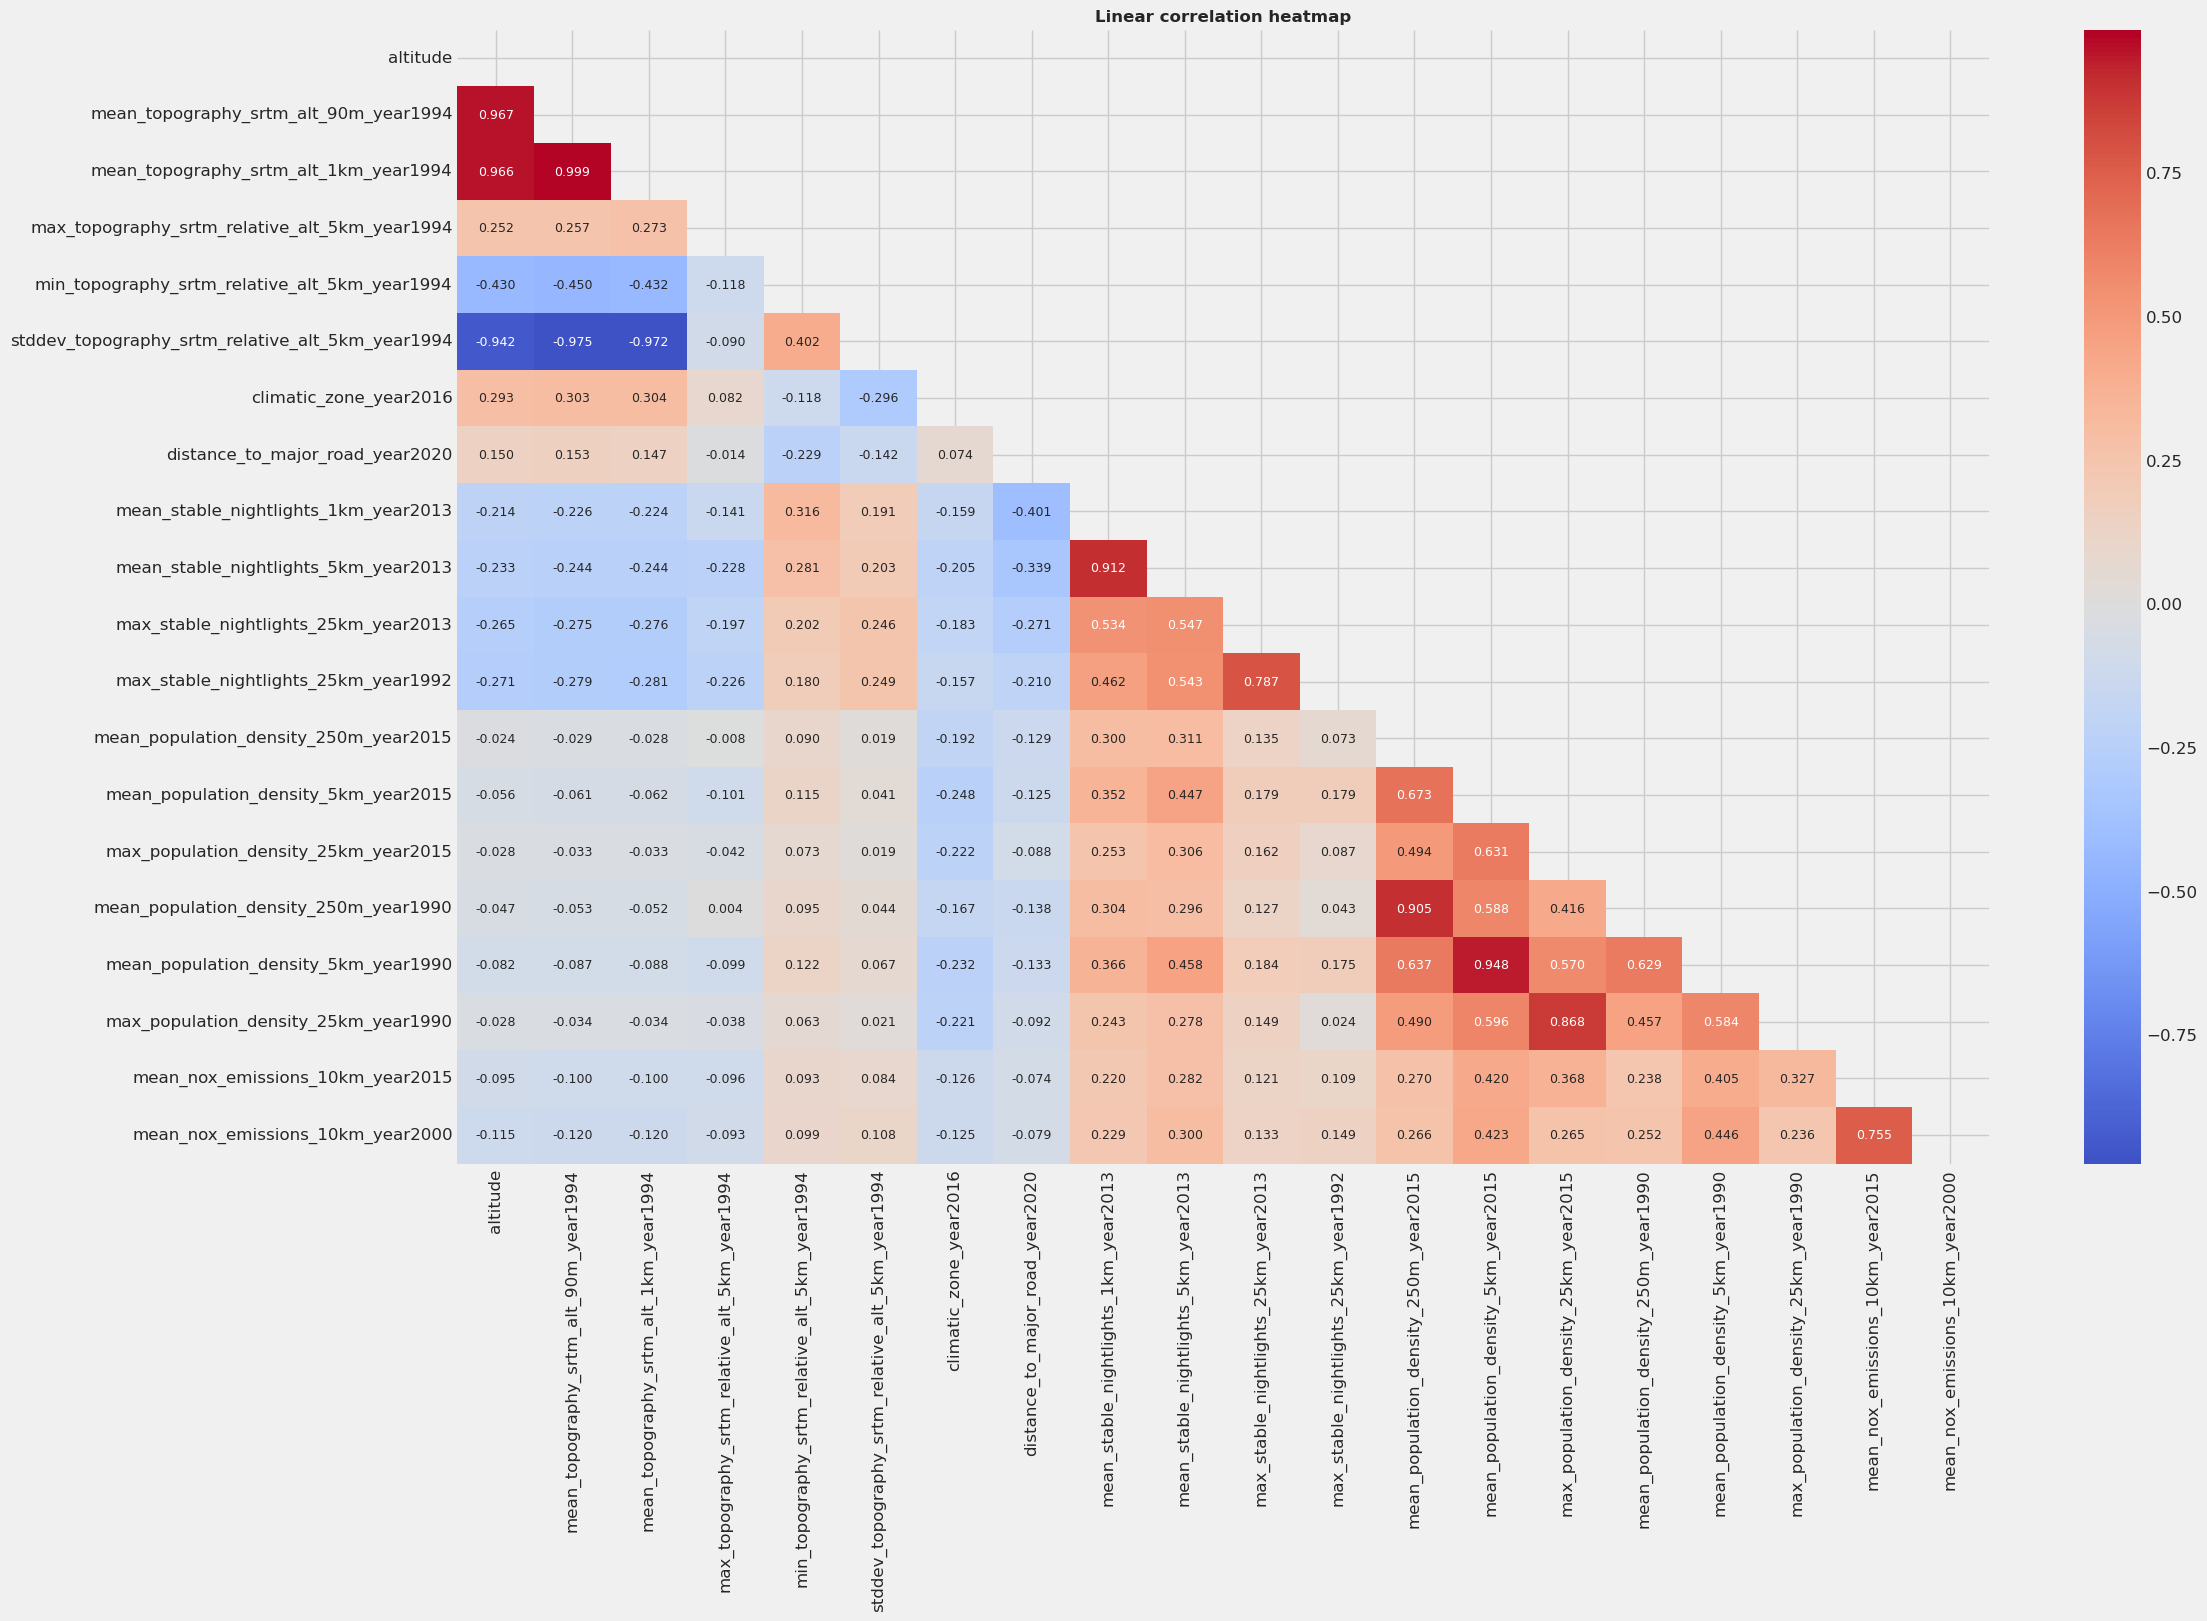

In [35]:
plot_correlation(df_train_0)

In [36]:
clustering_model_kmeans = train_clustering_model(df_train_0, model='kmeans')['model']

In [37]:
y_pred_0 = clustering_model_kmeans.predict(test_data_0)
display(y_pred_0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [38]:
test_data['category_pred']=y_pred_0
test_data['type_of_area_pred'] = test_data['category_pred'].map({0:'urban', 2:'suburban', 1:'rural'})
test_data = test_data[['area_code',	'type_of_are_toar', 'type_of_area_given', 'type_of_area_pred']]

accuracy_0 = accuracy_score(test_data['type_of_are_toar'].values, test_data['type_of_area_pred'].values)
accuracy_1 = accuracy_score(test_data['type_of_are_toar'].values, test_data['type_of_area_given'].values)

ari_0, nmi_0 = ari_nmi_clustering(test_data['type_of_are_toar'].values, test_data['type_of_area_pred'].values)
ari_1, nmi_1 = ari_nmi_clustering(test_data['type_of_are_toar'].values, test_data['type_of_area_given'].values)
print("Accuracy: {:.2f}%".format(accuracy_0*100))
print("ARI Score: {:.2f}".format(ari_0))
print("NMI Score: {:.2f}".format(nmi_0))
print()
print("Accuracy w.r.t given labels: {:.2f}%".format(accuracy_1*100))
print("ARI Score w.r.t given labels: {:.2f}".format(ari_1))
print("NMI Score w.r.t given labels: {:.2f}".format(nmi_1))

Accuracy: 93.94%
ARI Score: 0.77
NMI Score: 0.79

Accuracy w.r.t given labels: 87.88%
ARI Score w.r.t given labels: 0.66
NMI Score w.r.t given labels: 0.69


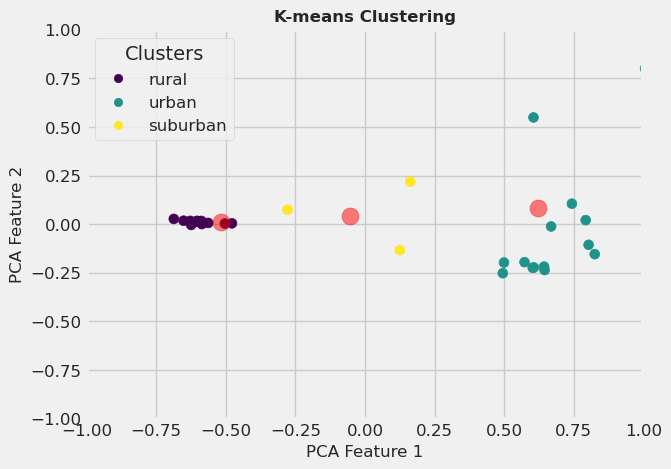

In [39]:
pca = PCA(n_components=2)
test_data_0_pca = pca.fit_transform(test_data_0)
# Plot the clusters
scatter = plt.scatter(test_data_0_pca[:, 0], test_data_0_pca[:, 1], c=y_pred_0, s=50, cmap='viridis')
# Plot centroids
centers = clustering_model_kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=150, alpha=0.5)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('K-means Clustering')
plt.legend(handles=scatter.legend_elements()[0], labels=['rural', 'urban', 'suburban'], loc="best", title="Clusters")
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.savefig('kmeans_clusters.png', dpi=300, pad_inches=0.2)
plt.show()

Accuracy: 64.60%


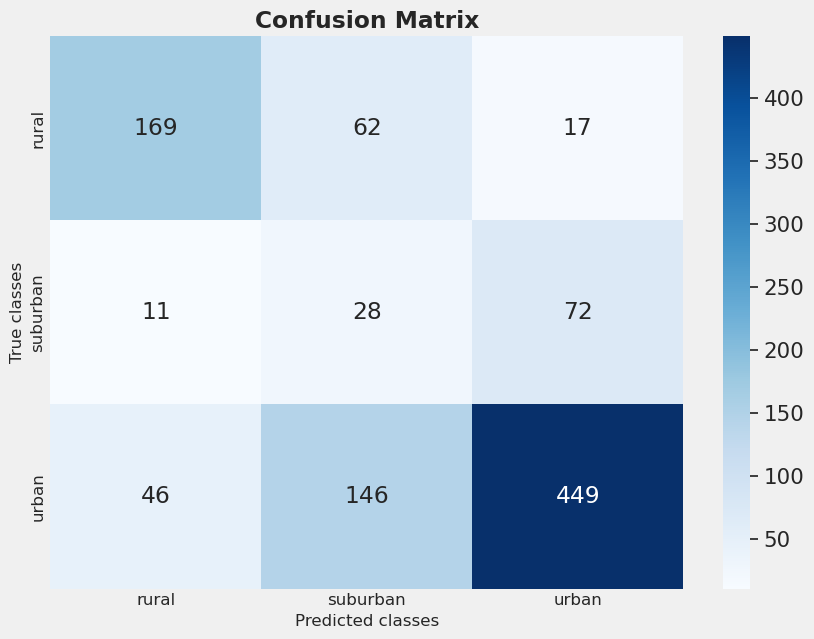

Accuracy: 64.60%
ARI Score : 0.23
NMI Score: 0.24


In [40]:
df_test_result = df_test[['area_code', 'type_of_area']]
y_pred_0 = clustering_model_kmeans.predict(df_test_0)
df_test_result['category_pred'] = y_pred_0
df_test_result['type_of_area_pred'] = df_test_result['category_pred'].map({0:'urban', 2:'suburban', 1:'rural'})
df_test_result = df_test_result[['area_code', 'type_of_area', 'type_of_area_pred']]
accuracy_0 = accuracy_score(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred'].values)
ari, nmi = ari_nmi_clustering(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred'].values)
cf_matrix_roc_auc(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred'].values, 
                 fig_name='confision_matrix_kmeans')
print("Accuracy: {:.2f}%".format(accuracy_0*100))
print("ARI Score : {:.2f}".format(ari))
print("NMI Score: {:.2f}".format(nmi))
#display(df_test_result)

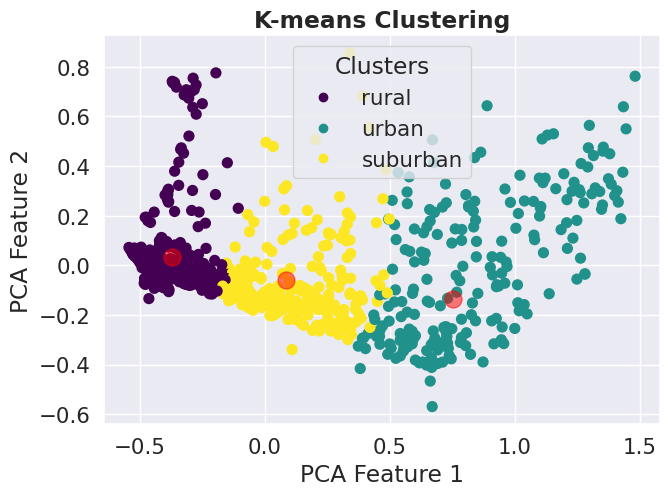

In [41]:
pca = PCA(n_components=2)
df_test_0_pca = pca.fit_transform(df_test_0)
# Plot the clusters
y_pred_0=clustering_model_kmeans.predict(df_test_0)
scatter = plt.scatter(df_test_0_pca[:, 0], df_test_0_pca[:, 1], c=y_pred_0, s=50, cmap='viridis')
# Plot centroids
centers = clustering_model_kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=150, alpha=0.5)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('K-means Clustering')
plt.legend(handles=scatter.legend_elements()[0], labels=['rural', 'urban', 'suburban'], loc="best", title="Clusters")
# plt.ylim((-1, 1))
# plt.xlim((-1, 1))
plt.show()

## Supervized learning approach

In [59]:
dataset = data_preprocessing(path_to_data='stationglobalmetadata_update.csv', dropna2=False)

Shape:  (23974, 22)
New shape:  (23974, 22)
Total points drop:  0


In [43]:
dataset.dropna(subset=nan_subset, how='all', inplace=True)
dataset.dropna(subset=nan_subset2, how='all', inplace=True)

In [44]:
dataset['altitude'].fillna(dataset['mean_topography_srtm_alt_90m_year1994'], inplace=True)
fillna = 'iter_imputer'
if fillna=='mean':
    dataset['distance_to_major_road_year2020'].fillna(dataset['distance_to_major_road_year2020'].mean(), inplace=True)
    dataset['mean_stable_nightlights_5km_year2013'].fillna(dataset['mean_stable_nightlights_5km_year2013'].mean(), inplace=True)
    dataset['max_stable_nightlights_25km_year2013'].fillna(dataset['max_stable_nightlights_25km_year2013'].mean(), inplace=True)
elif fillna=='iter_imputer':
    dataset = iterative_imputer(dataset, subset_to_impute=list(dataset.columns)[:-2])

In [45]:
def voting_clf(clfs:dict, X_test):
    y_pred_voting = []
    y_pred_rf = clfs['rf_clf'].predict(X_test)
    y_pred_cboost = clfs['cboost'].predict(X_test)
    y_pred_lgbm = clfs['lgbm'].predict(X_test)
    for pred in zip(y_pred_rf, y_pred_cboost, y_pred_lgbm):
        my_pred = (pred[0], pred[1][0], pred[2])
        counter = Counter(my_pred)
        y_pred_voting.append(counter.most_common(1)[0][0])
    return np.asarray(y_pred_voting, dtype=object)

def threshold_clf(y_proba:np.ndarray):
    y_pred = []
    for proba in list(y_proba):
        p_max = max(proba)
        if p_max == proba[1]:
            y_pred.append('suburban')
        elif p_max == proba[0] and p_max >= 0.5:
            y_pred.append('rural')
        elif p_max == proba[2] and p_max >= 0.5:
            y_pred.append('urban')
        else:
            y_pred.append('suburban')
    return np.asarray(y_pred, dtype=object)

In [46]:
dataset_origin = dataset.copy()
data = dataset_origin.sample(frac=1)

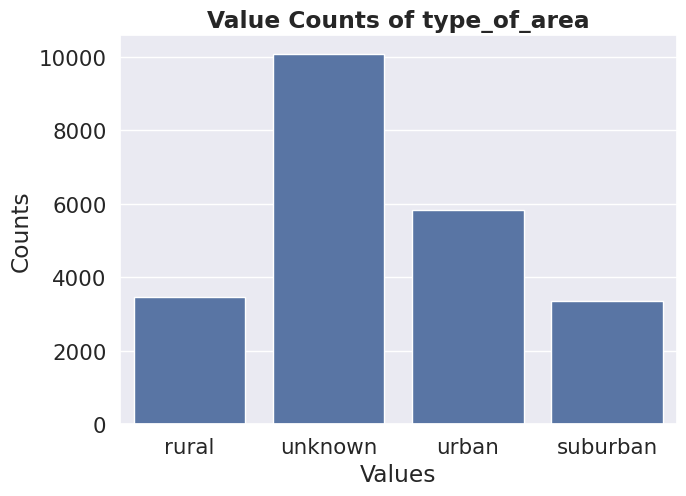

In [54]:
# Create a count plot using Seaborn
sns.countplot(data=dataset_origin, x='type_of_area')
plt.title('Value Counts of type_of_area')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

In [59]:
dataset_origin['type_of_area'].value_counts()

type_of_area
unknown     10076
urban        5830
rural        3453
suburban     3349
Name: count, dtype: int64

In [55]:
labelled_data = data[~(data['type_of_area']=='unknown')]
unlabelled_data = data[(data['type_of_area']=='unknown')]
print('number of data point: ', data.shape)
print("number of known station: ", labelled_data.shape)
print('number of unlabelled station: ', unlabelled_data.shape)
df_train, df_test = train_test_split(labelled_data, test_size=1000, shuffle=False, random_state=42)
print('training shape: ', df_train.shape)
print('test shape: ', df_test.shape)
df_test_idx = list(df_test.index)
df_train_idx = list(df_train.index)
labeled_idx = list(labelled_data.index)
unlabeled_idx = list(unlabelled_data.index)

number of data point:  (22708, 22)
number of known station:  (12632, 22)
number of unlabelled station:  (10076, 22)
training shape:  (11632, 22)
test shape:  (1000, 22)


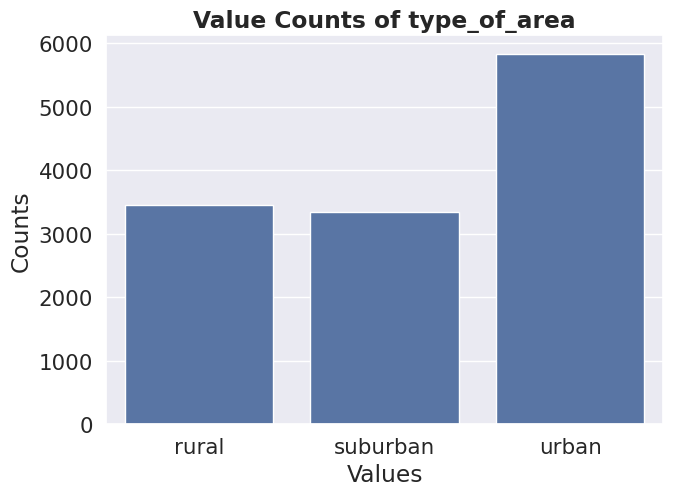

In [57]:
# Create a count plot using Seaborn
sns.countplot(data=labelled_data, x='type_of_area')
plt.title('Value Counts of type_of_area')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

In [58]:
labelled_data['type_of_area'].value_counts()

type_of_area
urban       5830
rural       3453
suburban    3349
Name: count, dtype: int64

In [48]:
test_data = get_test_data_from_station_code(test_cord)
test_data.set_index(['lat', 'lon'], inplace=True)
test_indeces = list(test_data.index)
test_indeces = [idx for idx in test_indeces if idx in list(labelled_data.index)]
test_data = test_data.loc[test_indeces]

In [49]:
columns_0 = [
    'altitude', 'mean_topography_srtm_alt_90m_year1994',
    'mean_topography_srtm_alt_1km_year1994',
    'max_topography_srtm_relative_alt_5km_year1994',
    'min_topography_srtm_relative_alt_5km_year1994',
    'stddev_topography_srtm_relative_alt_5km_year1994',
    'climatic_zone_year2016', 'distance_to_major_road_year2020',
    'mean_stable_nightlights_1km_year2013',
    'mean_stable_nightlights_5km_year2013',
    'max_stable_nightlights_25km_year2013',
    'max_stable_nightlights_25km_year1992',
    'mean_population_density_250m_year2015',
    'mean_population_density_5km_year2015',
    'max_population_density_25km_year2015',
    'mean_population_density_250m_year1990',
    'mean_population_density_5km_year1990',
    'max_population_density_25km_year1990',
    'mean_nox_emissions_10km_year2015', 
    'mean_nox_emissions_10km_year2000',
    'type_of_area'
]

columns_1 = [
    'mean_topography_srtm_alt_90m_year1994',
    'min_topography_srtm_relative_alt_5km_year1994',
    'stddev_topography_srtm_relative_alt_5km_year1994',
    'climatic_zone_year2016', 
    'distance_to_major_road_year2020',
    'mean_stable_nightlights_1km_year2013',
    'max_stable_nightlights_25km_year2013',
    'mean_population_density_250m_year2015',
    'mean_nox_emissions_10km_year2015', 
    'type_of_area'    
]


columns_2 = [
    'mean_topography_srtm_alt_1km_year1994',
    'max_topography_srtm_relative_alt_5km_year1994',
    'stddev_topography_srtm_relative_alt_5km_year1994',
    'climatic_zone_year2016', 
    'distance_to_major_road_year2020',
    'mean_stable_nightlights_5km_year2013',
    'max_stable_nightlights_25km_year2013',
    'mean_population_density_5km_year2015',
    'max_population_density_25km_year2015',
    'mean_nox_emissions_10km_year2015', 
    'type_of_area'
]


columns_3 = [
    'mean_topography_srtm_alt_90m_year1994',
    'max_topography_srtm_relative_alt_5km_year1994',
    'climatic_zone_year2016', 
    'distance_to_major_road_year2020',
    'mean_stable_nightlights_1km_year2013',
    'mean_stable_nightlights_5km_year2013',
    'max_stable_nightlights_25km_year2013',
    'mean_population_density_5km_year2015',
    'mean_nox_emissions_10km_year2015', 
    'type_of_area'
]
select_columns=[columns_0, columns_1, columns_2, columns_3]

In [50]:
cl_weights = {'urban': 0.275, 'suburban':0.45, 'rural':0.275}
param_grid = {
    'n_estimators': [100, 200, 250, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [51]:
for i, col in enumerate(select_columns):
    print(f'Training and evaluating for Columns {i} ')
    dataset_0 = feature_engineering_selection(data, selected_columns=col, scaling='robust', encode_cat=False)
    #plot_correlation(dataset_0[list(dataset_0.columns)[:-1]])
    print(len(df_train_idx))
    print(len(df_test_idx))
    print(len(unlabeled_idx))
    df_train_0 = dataset_0.loc[df_train_idx]
    df_test_0 = dataset_0.loc[df_test_idx]
    print('training shape', df_train_0.shape)
    print('test shape: ', df_test_0.shape)
    df_unlabeled_0 = dataset_0.loc[unlabeled_idx]
    test_data_0 = dataset_0.loc[test_indeces]
    #display(df_train_0.head(2))
    X_train_0 = df_train_0.drop(columns=['type_of_area'])
    Y_train_0 = df_train_0[['type_of_area']]
    X_test_0 = df_test_0.drop(columns=['type_of_area'])
    Y_test_0 = df_test_0[['type_of_area']]

    rf_clf = RandomForestClassifier(n_estimators=500, criterion = 'entropy', random_state = 42, class_weight=cl_weights)
    cboost_clf = CatBoostClassifier(verbose=False)
    lgbm_clf =  LGBMClassifier(verbose=0)

    rf_clf.fit(X_train_0, Y_train_0)
    cboost_clf.fit(X_train_0, Y_train_0)
    lgbm_clf.fit(X_train_0, Y_train_0)

    y_pred_prob_rf=rf_clf.predict_proba(test_data_0.drop(columns=['type_of_area']))
    y_pred_prob_cboost=cboost_clf.predict_proba(test_data_0.drop(columns=['type_of_area']))
    y_pred_prob_lgbm=lgbm_clf.predict_proba(test_data_0.drop(columns=['type_of_area']))
    y_pred_prob_voting = (y_pred_prob_rf + y_pred_prob_cboost + y_pred_prob_lgbm)/3
    rf_clf.classes_

    y_pred_0 = rf_clf.predict(test_data_0.drop(columns=['type_of_area']))
    test_data['type_of_area_pred_rf'] = y_pred_0
    Acc_0 = accuracy_score(test_data['type_of_are_truth'].values, test_data['type_of_area_pred_rf'].values)
    Acc_1 = accuracy_score(test_data['type_of_area_given'].values, test_data['type_of_area_pred_rf'].values)
    print("Accuracy w.r.t truth labels : {:.2f}%".format(Acc_0*100))
    print("Accuracy w.r.t given labels: {:.2f}%".format(Acc_1*100))

    y_pred_0_rf = threshold_clf(rf_clf.predict_proba(X_test_0))
    y_pred_0_cboost = cboost_clf.predict(X_test_0)
    y_pred_0_lgbm = lgbm_clf.predict(X_test_0)
    y_pred_0_voting = voting_clf({'rf_clf': rf_clf, 'cboost': cboost_clf, 'lgbm': lgbm_clf}, X_test_0)
    
    df_test_result = df_test[['area_code', 'type_of_area']]
    df_test_result['type_of_area_pred_rf'] = y_pred_0_rf
    df_test_result['type_of_area_pred_cboost'] = y_pred_0_cboost.reshape(len(y_pred_0_rf), )
    df_test_result['type_of_area_pred_lgbm'] = y_pred_0_lgbm
    df_test_result['type_of_area_pred_voting'] = y_pred_0_voting

    print('Random forest accuracy: ', accuracy_score(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred_rf'].values))
    print('catboost accuracy: ', accuracy_score(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred_lgbm'].values))
    print('lgbm accuracy: ', accuracy_score(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred_cboost'].values))
    print('voting accuracy: ', accuracy_score(df_test_result['type_of_area'].values, df_test_result['type_of_area_pred_voting'].values))
    
    urban_pred = df_test_result[df_test_result['type_of_area']=='urban']
    suburban_pred = df_test_result[df_test_result['type_of_area']=='suburban']
    rural_pred = df_test_result[df_test_result['type_of_area']=='rural']
    
    print()
    print("accuraccy for separate test, random forest")
    print('accuracy of predicting urban', accuracy_score(urban_pred['type_of_area'].values, urban_pred['type_of_area_pred_rf'].values))
    print('accuracy of predicting rural', accuracy_score(rural_pred['type_of_area'].values, rural_pred['type_of_area_pred_rf'].values))
    print('accuracy of predicting suburan', accuracy_score(suburban_pred['type_of_area'].values, suburban_pred['type_of_area_pred_rf'].values))
    
    print()
    print("accuraccy for separate test, random forest")
    print('accuracy of predicting urban lgbm: ', accuracy_score(urban_pred['type_of_area'].values, urban_pred['type_of_area_pred_lgbm'].values))
    print('accuracy of predicting rural lgbm: ', accuracy_score(rural_pred['type_of_area'].values, rural_pred['type_of_area_pred_lgbm'].values))
    print('accuracy of predicting suburan lgbm: ', accuracy_score(suburban_pred['type_of_area'].values, suburban_pred['type_of_area_pred_lgbm'].values))
    
    print()
    print("accuraccy for separate test, random forest")
    print('accuracy of predicting urban cboost: ', accuracy_score(urban_pred['type_of_area'].values, urban_pred['type_of_area_pred_cboost'].values))
    print('accuracy of predicting rural cboost: ', accuracy_score(rural_pred['type_of_area'].values, rural_pred['type_of_area_pred_cboost'].values))
    print('accuracy of predicting suburan cboost: ', accuracy_score(suburban_pred['type_of_area'].values, suburban_pred['type_of_area_pred_cboost'].values))
    
    print()
    print("accuraccy for separate test, voting")
    print('accuracy of predicting urban', accuracy_score(urban_pred['type_of_area'].values, urban_pred['type_of_area_pred_voting'].values))
    print('accuracy of predicting rural', accuracy_score(rural_pred['type_of_area'].values, rural_pred['type_of_area_pred_voting'].values))
    print('accuracy of predicting suburan', accuracy_score(suburban_pred['type_of_area'].values, suburban_pred['type_of_area_pred_voting'].values))

    cf_matrix_roc_auc(
    df_test_result['type_of_area'].values,
    df_test_result['type_of_area_pred_rf'].values,
    fig_name='confusion_matrix_rf')
    df_test_result['type_of_area'].value_counts()

    cf_matrix_roc_auc(
    df_test_result['type_of_area'].values,
    df_test_result['type_of_area_pred_voting'].values,
    fig_name='confusion_matrix_voting')
    df_test_result['type_of_area'].value_counts()
    print()

Training and evaluating for Columns 0 
11632
1000
10076
training shape (11633, 21)
test shape:  (1001, 21)
Accuracy w.r.t truth labels : 100.00%
Accuracy w.r.t given labels: 86.67%


ValueError: Length of values (1001) does not match length of index (1000)

In [ ]:
importance = rf_clf.feature_importances_
feature_rank = pd.DataFrame({'feature': list(X_train_0.columns), 'importance': importance})
feature_rank = feature_rank.sort_values('importance', ascending=False)
features = feature_rank['feature'].to_list()
important_features = features[:]
plt.figure(figsize=(12, 14))
sns.barplot(y='feature', x='importance', data=feature_rank)
plt.title(f"feature importance for rf_clf", size=10)
plt.show()